# Imports

In [2]:
using CSV, DataFrames, MarketData, Statistics, Ipopt, JuMP, Plots,Dates, LinearAlgebra, GLM, MultivariateStats
using NearestNeighbors, ARCHModels, Random, Dates, FinancialToolbox
find(x)=findall(x1 -> x1,vec(x))

find (generic function with 1 method)

# Question 1

## Part a

## Part b

# Question 2

## Part a

### European Put Option Price

In [5]:
blsprice(10,10.5,.04,.25,.2,0,false)

0.6346109503233762

We use a 5x5 matrix here to find the option rather than the proposed $\frac{n(n + 1)}{2}$ length array. This allows us to efficiently loop to create prices, IVs and constraints for each model. Additionally, it's easier for me to interpret, as each column corresponds to a new time step

### American Binomial and Hybrid Model

In [6]:
S = 10
K = 10.5
r = 0.01/4

u=1+0.1/sqrt(4);
d=1-0.1/sqrt(4);

s = zeros(5,5) # This gives us a matrix where each column represents a time step. Top row is all up moves
iv = zeros(5,5)
for j in 1:5
    for i in 1:5
        s[i,j] = S * u^(j - i) * d^(i - 1)
        iv[i,j] = max(K - s[i,j], 0)
        if i == j
            break
        end
    end
end

model1=Model(Ipopt.Optimizer)
@variable(model1,0<=p<=1)
set_silent(model1)
@constraint(model1,10*(1+0.1/sqrt(4))*p+10*(1-0.1/sqrt(4))*(1-p)==10*(1+r))
optimize!(model1)
p=value(p)

model2=Model(Ipopt.Optimizer)
@variable(model2,0<=w[1:4, 1:4]<=1)
@variable(model2,val[1:5, 1:5]>=0)
set_silent(model2)
for i in 1:5
    @constraint(model2, val[i, 5] == iv[i, 5])
end

for i in 1:4
    for j in 1:4
        @constraint(model2,val[i,j]==w[i, j]*((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r)+(1-w[i,j])*iv[i,j])
    end
end
@objective(model2,Max,val[1,1])
optimize!(model2)
println([value(val[1,1]) find(value.(w).<.001)'])

model3=Model(Ipopt.Optimizer)
@variable(model3,0<=w[1:4, 1:4]<=1)
@variable(model3,val[1:5, 1:5]>=0)
set_silent(model3)
for i in 1:5
    @constraint(model3, val[i, 5] == iv[i, 5])
end

for i in 1:4
    for j in 1:4
        if j == 4
            @constraint(model3,val[i,j]==w[i, j]*blsprice(s[i,j],K,.04,1/16,.2,0,false)+(1-w[i,j])*iv[i,j])
        else
            @constraint(model3,val[i,j]==w[i, j]*((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r)+(1-w[i,j])*iv[i,j])
        end
    end
end
@objective(model3,Max,val[1,1]+.01*sum((w[i,j]-.5)^2 for i in 1:4 for j in 1:4 if i <= j)) # Shorthand for loop which sums all w inside upper triangle
optimize!(model3)
println([value(val[1,1]) find(value.(w).<.001)'])


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

[

0.6734406864246626 11.0 15.0]


[0.6474261811725217 13.0 15.0 16.0]


### European Binomial and Hybrid Model

In [14]:
S = 10
K = 10.5
r = 0.01/4

u=1+0.1/sqrt(4);
d=1-0.1/sqrt(4);

s = zeros(5,5) # This gives us a matrix where each column represents a time step. Top row is all up moves
iv = zeros(5,5)
for j in 1:5
    for i in 1:5
        s[i,j] = S * u^(j - i) * d^(i - 1)
        iv[i,j] = max(K - s[i,j], 0)
        if i == j
            break
        end
    end
end

model1=Model(Ipopt.Optimizer)
@variable(model1,0<=p<=1)
set_silent(model1)
@constraint(model1,10*(1+0.1/sqrt(4))*p+10*(1-0.1/sqrt(4))*(1-p)==10*(1+r))
optimize!(model1)
p=value(p)

model2=Model(Ipopt.Optimizer)
@variable(model2)
@variable(model2,val[1:5, 1:5]>=0)
set_silent(model2)
for i in 1:5
    @constraint(model2, val[i, 5] == iv[i, 5])
end

for i in 1:4
    for j in 1:4
        @constraint(model2,val[i,j]==((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r))
    end
end
@objective(model2,Max,val[1,1])
optimize!(model2)
println(value(val[1,1]))
# show(stdout, "text/plain", reshape(value.(val), (5, 5)))

model3=Model(Ipopt.Optimizer)
@variable(model3,val[1:5, 1:5]>=0)
set_silent(model3)
for i in 1:5
    @constraint(model3, val[i, 5] == iv[i, 5])
end

for i in 1:4
    for j in 1:4
        if j == 4
            @constraint(model3,val[i,j]==blsprice(s[i,j],K,.04,1/16,.2,0,false))
        else
            @constraint(model3,val[i,j]==((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r))
        end
    end
end
@objective(model3,Max,val[1,1]+.01*sum((.5)^2 for i in 1:4 for j in 1:4 if i <= j)) # Shorthand for loop which sums all w inside upper triangle
optimize!(model3)
println(value(val[1,1]))

[0.655541457449106]


5×5 Matrix{Float64}:
 

    0.655541      0.353266      0.123462  -2.17706e-41  -2.86986e-42
 19397.0           0.993086      0.609119   0.260569      0.0
 62190.6       40936.8           1.4227     0.997565      0.549938
 83651.3       86009.0       86396.6        1.90007       1.49756
 82178.4       81485.7       86033.2        1.8234e5      2.35494

0.6375435724331996


## Part b

In [16]:
function Binomial4Step(S, K)
    r = 0.01/4

    u=1+0.1/sqrt(4);
    d=1-0.1/sqrt(4);

    s = zeros(5,5) # This gives us a matrix where each column represents a time step. Top row is all up moves
    iv = zeros(5,5)
    for j in 1:5
        for i in 1:5
            s[i,j] = S * u^(j - i) * d^(i - 1)
            iv[i,j] = max(K - s[i,j], 0)
            if i == j
                break
            end
        end
    end

    model1=Model(Ipopt.Optimizer)
    @variable(model1,0<=p<=1)
    set_silent(model1)
    @constraint(model1,10*(1+0.1/sqrt(4))*p+10*(1-0.1/sqrt(4))*(1-p)==10*(1+r))
    optimize!(model1)
    p=value(p)

    model2=Model(Ipopt.Optimizer)
    @variable(model2,0<=w[1:4, 1:4]<=1)
    @variable(model2,val[1:5, 1:5]>=0)
    set_silent(model2)
    for i in 1:5
        @constraint(model2, val[i, 5] == iv[i, 5])
    end

    for i in 1:4
        for j in 1:4
            @constraint(model2,val[i,j]==w[i, j]*((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r)+(1-w[i,j])*iv[i,j])
        end
    end
    @objective(model2,Max,val[1,1])
    optimize!(model2)
    return value(val[1,1])
end
function Hybrid4Step(S, K)
    r = 0.01/4

    u=1+0.1/sqrt(4);
    d=1-0.1/sqrt(4);

    s = zeros(5,5) # This gives us a matrix where each column represents a time step. Top row is all up moves
    iv = zeros(5,5)
    for j in 1:5
        for i in 1:5
            s[i,j] = S * u^(j - i) * d^(i - 1)
            iv[i,j] = max(K - s[i,j], 0)
            if i == j
                break
            end
        end
    end

    model1=Model(Ipopt.Optimizer)
    @variable(model1,0<=p<=1)
    set_silent(model1)
    @constraint(model1,10*(1+0.1/sqrt(4))*p+10*(1-0.1/sqrt(4))*(1-p)==10*(1+r))
    optimize!(model1)
    p=value(p)

    model3=Model(Ipopt.Optimizer)
    @variable(model3,0<=w[1:4, 1:4]<=1)
    @variable(model3,val[1:5, 1:5]>=0)
    set_silent(model3)
    for i in 1:5
        @constraint(model3, val[i, 5] == iv[i, 5])
    end

    for i in 1:4
        for j in 1:4
            if j == 4
                @constraint(model3,val[i,j]==w[i, j]*blsprice(s[i,j],K,.04,1/16,.2,0,false)+(1-w[i,j])*iv[i,j])
            else
                @constraint(model3,val[i,j]==w[i, j]*((1-p)*val[i + 1, j + 1]+p*val[i, j + 1])/(1+r)+(1-w[i,j])*iv[i,j])
            end
        end
    end
    @objective(model3,Max,val[1,1]+.01*sum((w[i,j]-.5)^2 for i in 1:4 for j in 1:4 if i <= j)) # Shorthand for loop which sums all w inside upper triangle
    optimize!(model3)
    return value(val[1,1])


end;

In [17]:
BinPrices = zeros(5)
HybridPrices = zeros(5)
EuPrices = zeros(5)
i = 1
for price in range(9, stop = 11, step = 0.5)
    BinPrices[i] = Binomial4Step(10, price)
    HybridPrices[i] = Hybrid4Step(10, price)
    EuPrices[i] = blsprice(10,price,.04,.25,.2,0,false)
    i += 1
end
TheoreticalPrices = [0.06, 0.16, 0.36, 0.65, 1.04]; # From Wolfram Alpha

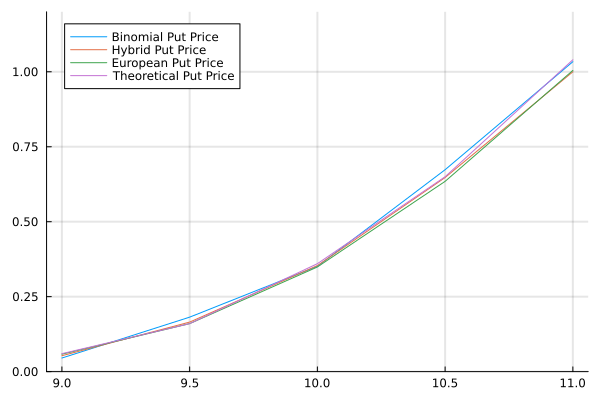

In [26]:
x = range(9, stop = 11, step = 0.5)
plot(x, BinPrices, label = "Binomial Put Price", grid=true,gridlinewidth = 2, ylim = (0,1.2))
plot!(x, HybridPrices, label = "Hybrid Put Price", grid=true)
plot!(x, EuPrices, label = "European Put Price", grid=true)
plot!(x, TheoreticalPrices, label = "Theoretical Put Price", grid=true)